# **심화실습 03-01 : VGG Model Fine Tuning**

## **Import Module**

In [0]:
%tensorflow_version 2.x


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing import image
import tensorflow.keras as keras
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

## **Dataset Load**

### Load tf_flowers

In [0]:
import pathlib
data_dir = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)
print (data_dir)

228818944/228813984 [==============================] - 5s 0us/step
/root/.keras/datasets/flower_photos


### 저장된 이미지를 `ImageDataGenerator()`로 준비하기

### Check Images

In [0]:
# 지정 폴더 아래에 있는 모든 *.jpg 파일의 수
#  및 폴더명 목록을 리턴  
def check_dir(d_path):
  img_count = len(list(d_path.glob('*/*.jpg')))
  c_name = np.array([item.name for item in d_path.glob('*') if item.name != "LICENSE.txt"])
  return img_count, c_name, len(c_name)

In [0]:
# check_dir()로 폴더명과 이미지 숫자 확인
image_count, CLASS_NAMES, class_num = check_dir(data_dir)

print('image_count: {}\nclasses: {}'.format(image_count, CLASS_NAMES))

image_count: 3670
classes: ['sunflowers' 'roses' 'daisy' 'dandelion' 'tulips']


### ImageDataGenerator

In [0]:
# Imagae size 결정 **
IN_IMG_SIZE = 224

In [0]:
# image generator
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = (image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
                      #width_shift_range=0.1,
                      #height_shift_range=0.1,
                      #horizontal_flip=True, 
                      #vertical_flip=True,
                      #rotation_range=30,
                      #zoom_range=0.1,
                      #brightness_range=[0.8,2.0],
                      validation_split=0.2,
                      rescale=1./255))

batch_n = 128

# generate train dataset
train_data_gen = image_generator.flow_from_directory(
                      directory=str(data_dir),
                      batch_size=batch_n,
                      target_size=(IN_IMG_SIZE, IN_IMG_SIZE),
                      classes = list(CLASS_NAMES),
                      subset='training')
# generate test dataset
test_data_gen = image_generator.flow_from_directory(
                        directory=str(data_dir),
                        batch_size=batch_n,
                        shuffle=True,
                        target_size=(IN_IMG_SIZE, IN_IMG_SIZE),
                        classes = list(CLASS_NAMES),
                        subset='validation'
                        )


Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


## **Load ResNet50 model**

In [0]:
import tensorflow.keras.applications.inception_v3 as incept

In [0]:

# load pretrained model
model_pretrained = incept.InceptionV3(
    weights='imagenet',
    include_top=False,    # dense layer 이 후는 제외
    input_tensor=keras.layers.Input(shape=(IN_IMG_SIZE, IN_IMG_SIZE, 3))
    )
 
# summarize the model
model_pretrained.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

### **마지막 `conv layer`만 남기고 나머지는 전부 frozen 시킨다.**   
- ### 마지막 conv layer가 fine tuning 됨 


In [0]:
# Freeze the layers except the last 4 layers
for layer in model_pretrained.layers[:]: # [:-31]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
#for layer in model_pretrained.layers:
#    print(layer, layer.trainable)

### **VGG 결과를 받아 dense(relu) + dropout + dense(softmax)를 추가하여 classification model 완성**
- ***batch normalizatin을 필히 사용할 것***

In [0]:
# Create a new fine tuning model
model_fine = keras.models.Sequential()
model_fine.add(model_pretrained)
# Add new layers
model_fine.add(keras.layers.GlobalAveragePooling2D())
#model_fine.add(keras.layers.Flatten())
#model_fine.add(keras.layers.Dense(1024, activation='relu'))
#model_fine.add(keras.layers.Dropout(0.5))
#model_fine.add(keras.layers.LeakyReLU(alpha=0.1))
#model_fine.add(keras.layers.BatchNormalization())   # 필히 사용할 것
model_fine.add(keras.layers.Dense(class_num, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model_fine.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


## **Compile**

In [0]:
# Compile the model
model_fine.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## **Fit**

In [0]:
%%time
# reset data generator
train_data_gen.reset()
test_data_gen.reset()
'''
history = model_fine.fit_generator(train_data_gen, 
                        #steps_per_epoch=50,
                        epochs=30,
                        validation_data=test_data_gen
                        )
'''

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 12.9 µs


## gradient model

In [0]:
x = model_pretrained.get_layer('mixed7').output
print(type(x), x.shape)
# Add the vgg convolutional base model
x=keras.layers.Conv2D(128, 3, padding='same', activation='relu', name='conv_feat')(x)
#x=keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
#x=keras.layers.BatchNormalization()(x)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(class_num, activation='softmax')(x)
model_fine_2 = Model([model_pretrained.inputs],
              [x]
              )

#grad_model.summary()

<class 'tensorflow.python.framework.ops.Tensor'> (None, 12, 12, 768)


In [0]:
model_fine_2.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# Compile the model
model_fine_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
%%time
# reset data generator
train_data_gen.reset()
test_data_gen.reset()

history_2 = model_fine_2.fit_generator(train_data_gen, 
                        #steps_per_epoch=50,
                        epochs=30,
                        validation_data=test_data_gen
                        )


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 23 steps, validate for 6 steps
Epoch 1/30
23/23 [==============================] - 53s 2s/step - loss: 1.1884 - accuracy: 0.5369 - val_loss: 1.5352 - val_accuracy: 0.5677
Epoch 2/30
23/23 [==============================] - 48s 2s/step - loss: 0.4516 - accuracy: 0.8431 - val_loss: 0.9351 - val_accuracy: 0.7483
Epoch 3/30
23/23 [==============================] - 48s 2s/step - loss: 0.3247 - accuracy: 0.8874 - val_loss: 0.6280 - val_accuracy: 0.8098
Epoch 4/30
23/23 [==============================] - 49s 2s/step - loss: 0.2716 - accuracy: 0.9027 - val_loss: 0.8281 - val_accuracy: 0.7907
Epoch 5/30
23/23 [==============================] - 48s 2s/step - loss: 0.2117 - accuracy: 0.9272 - val_loss: 0.7061 - val_accuracy: 0.8016
Epoch 6/30
23/23 [==============================] - 48s 2s/step - loss: 0.1914 - accuracy: 0.9309 - val_loss: 0.6788 - val_accuracy: 

In [0]:
# tf.keras.models.Model -> functional model
grad_model = tf.keras.models.Model(
    [model_fine_2.inputs],                           # input: vgg16 inputs
    [model_fine_2.get_layer('conv_feat').output,  # outputs: vgg16 last conv
     model_fine_2.output]                            # softmax out
)


In [0]:
roses = list(data_dir.glob('roses/*'))

In [0]:
img_path = roses[0]

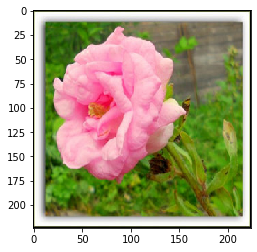

In [0]:
# load the image with the required shape
img = image.load_img(img_path, target_size=(224, 224))
# check image
plt.imshow(img)
# convert the image to an array
img = image.img_to_array(img)         # tf.keras.processing
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)     # numpy
# prepare the image (e.g. scale pixel values for the vgg)
img = incept.preprocess_input(img)     # Inception.preprocess_input


### Build CAM

In [0]:
# GradientTape 설정
with tf.GradientTape() as tape:
    conv_outputs, predict = grad_model(img)   # feature, predict
    class_out = predict[:, np.argmax(predict[0])]    # class     

# feature map
output = conv_outputs[0]

# Get gradient for input image
grads = tape.gradient(class_out, conv_outputs)[0]

# check grads' shape
grads.shape, output.shape

(TensorShape([12, 12, 128]), TensorShape([12, 12, 128]))

In [0]:
output.shape, predict

(TensorShape([12, 12, 128]), <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[2.3628911e-12, 9.8859298e-01, 2.8210434e-07, 4.1011985e-16,
         1.1406824e-02]], dtype=float32)>)

In [0]:
# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1))

# Build a map of filters according to gradients importance
cam = np.ones(output.shape[0:2], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, index]

# check cam shape
cam.shape, weights.shape

(TensorShape([12, 12]), TensorShape([128]))

In [0]:
str(img_path)

'/root/.keras/datasets/flower_photos/roses/7409458444_0bfc9a0682_n.jpg'

((277, 320, 3), numpy.ndarray)

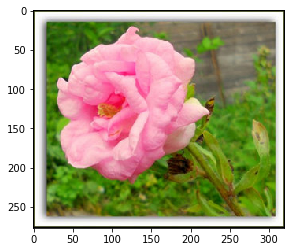

In [0]:
import cv2

# image read: ndarray type
img = cv2.imread(str(img_path))
# GBR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # cv2는 기본적으로 image를 GBR로 처리

plt.imshow(img)

img.shape, type(img)

(277, 320, 3)

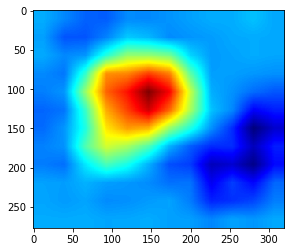

In [0]:
# resize cam
cam = cv2.resize(cam.numpy(), (img.shape[1], img.shape[0]))
cam = np.maximum(cam, 0)          # 0 이상의 값만 취함
# heatmap : minmax normalized one
heatmap_1 = (cam - cam.min()) / (cam.max() - cam.min())

# convert heatmap to rgb0
heatmap = np.uint8(255 * heatmap_1)                       # RGB range (0~255)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # apply color map
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)      # colormap to RGB

# check heatmap shape
plt.imshow(heatmap)
heatmap.shape


### Blending heatmap on image

In [0]:
from scipy import ndimage
from skimage.measure import regionprops

def generate_bbox(cam, threshold):
    labeled, _ = ndimage.label(cam > threshold)
    props = regionprops(labeled)
    return props

In [0]:
# blending heatmap: image: 100%, heatmap: 50%
output_image = cv2.addWeighted(img.astype('uint8'), 1,  # 1: 100%
                               heatmap, 0.5,            # 0.5: 50%
                               0)

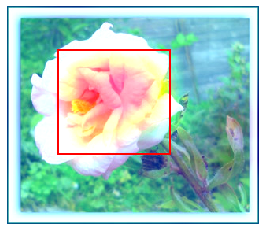

In [0]:
import matplotlib.patches as patches

# Create figure and axes
fig,ax = plt.subplots(1)
# plot blended image
#plt.imshow(output_image)
plt.axis('off')
#plt.title(incept.decode_predictions(preds, top=2)[0][0][1])

ax.imshow(output_image)

props = generate_bbox(heatmap_1, 0.5)
for b in props:
    bbox = b.bbox
    xs = bbox[1]
    ys = bbox[0]
    w = bbox[3] - bbox[1]
    h = bbox[2] - bbox[0]


rect = patches.Rectangle((xs, ys), w, h, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

## **Analysis**

In [0]:
history=history_2
print(np.max(history.history['val_accuracy']))

0.8590971


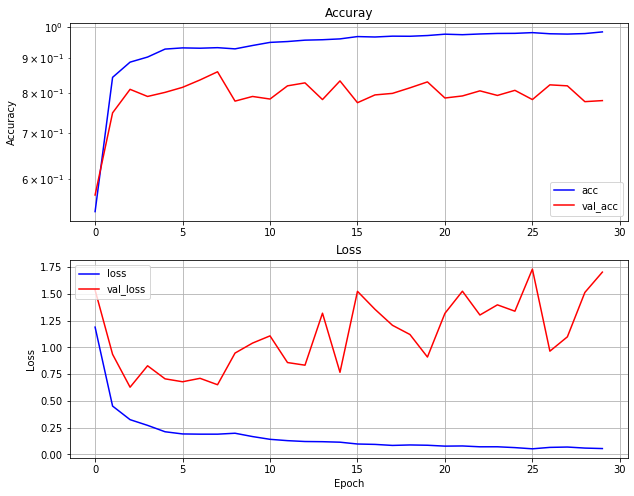

In [0]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title('Accuray')
plt.semilogy(history.history['accuracy'], 'b', label='acc')
plt.semilogy(history.history['val_accuracy'], 'r', label='val_acc')
plt.grid(True)
plt.ylabel('Accuracy')
#plt.ylim([0.95, 1])
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.title('Loss')
plt.plot(history.history['loss'], 'b', label='loss')
plt.plot(history.history['val_loss'], 'r', label='val_loss')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.0, 0.2])
plt.legend(loc='best')
plt.show()


## **실습 과제**

### 과제1 결과를 분석해 보자
#### -- 만족스러운가?
#### -- 원인을 분석해 보자

### 과제2
#### -- 분석된 결과를 바탕으로 개선 방안을 찾고 적용해 보자